# Cropping Calibration Notebook for a Computer Vision Dataset

This notebook implements a **calibration step** for image cropping within an AI / Computer Vision pipeline.

## Why do this?

In practical ML workflows, raw images often contain:
- irrelevant borders (camera padding, black bars, UI overlays),
- inconsistent framing across samples,
- background regions that add noise.

A controlled cropping step helps:
- standardize the **region of interest (ROI)**,
- reduce input variability,
- improve the *signal-to-noise ratio*,
- make training and evaluation more comparable across experiments.

## Key idea

We select the crop parameters **once** on a reference image (typically the first one),
then we **save** those parameters to JSON for reproducibility, and finally we can apply the crop in batch.

This notebook is intentionally split from the cropping implementation:
- the reusable code lives in the `cropping/` module (e.g., `CropConfig`, `BatchCropper`),
- this notebook is only for selecting and exporting the correct parameters.


## 0) Project integration

This notebook assumes you already have a local module called `cropping` (Python package) that contains:
- `CropConfig`: a small configuration object (left/top/right/bottom),
- `BatchCropper`: the class that applies the crop and can save/load config,
- `CROPPING_HELPERS`: helper functions for listing/loading images.

Once the JSON config is saved in your dataset folder, the rest of your codebase can simply do:

```python
from cropping import BatchCropper
cropper = BatchCropper.load_config(DATASET_DIR)
```

This pattern keeps your preprocessing **reusable**, **testable**, and **experiment-friendly**.


## 1) Imports

We use:
- **Pillow** for image I/O,
- **matplotlib** for visualization,
- **ipywidgets** for interactive slider-based crop selection,
- your own `cropping` module for the actual implementation.

> If you run into widget issues in Jupyter, ensure `ipywidgets` is installed and enabled.


In [1]:
from config_loader import CONFIG

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
from PIL import Image

from cropping import CropConfig, BatchCropper, CROPPING_HELPERS

import ipywidgets as widgets
from IPython.display import display, clear_output

plt.rcParams["figure.figsize"] = (8, 6)


## 2) Dataset path and basic visualization helper

Set your dataset folder and image extensions.

The helper `show_image()` is used to quickly display the reference image and crop previews.


In [3]:
DATASET_DIR = Path(r"C:\Users\floot\Florian's Laptop\ESILV\CV and Deep Learning\ESILV_A5_Computer_Vision\dataset_creation\assets\frames_from_videos_clips")
IMG_EXT = {".jpg"}

def show_image(img: Image.Image, title: str = ""):
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


## 3) Load a reference image (first image in the folder)

We use the **first image** in the folder as a reference to define the crop.
This is a common approach when the dataset comes from a stable acquisition process
(e.g., same camera, same viewpoint, same framing).

If your dataset has strong variability, you may need per-image cropping (e.g., automatic ROI detection).


Found 440 images in: C:\Users\floot\Florian's Laptop\ESILV\CV and Deep Learning\ESILV_A5_Computer_Vision\dataset_creation\assets\frames_from_videos_clips
Reference image: Power Blackjack Live Casino Game By Evolution _ Mystake - Opera 2025-10-06 21-42-58-00.00.00.000-00.00.05.916-seg01_000001.jpg | size=(2448, 1440)


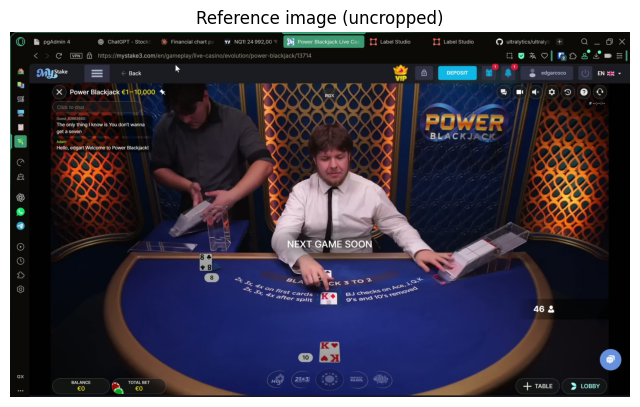

In [4]:
image_paths = CROPPING_HELPERS.list_images(DATASET_DIR, IMG_EXT)
print(f"Found {len(image_paths)} images in: {DATASET_DIR.resolve()}")

if not image_paths:
    raise ValueError("No images found. Check DATASET_DIR and SUPPORTED_EXTS.")

ref_path = image_paths[0]
ref_img = CROPPING_HELPERS.load_image(ref_path)
w, h = ref_img.size

print(f"Reference image: {ref_path.name} | size=({w}, {h})")
show_image(ref_img, title="Reference image (uncropped)")


## 4) Interactive crop selection

You will select **four integer values**:
- `left` and `right` for horizontal bounds,
- `top` and `bottom` for vertical bounds.

The UI updates a cropped preview in real-time.

**Coordinate convention (PIL)**
The crop box is `(left, top, right, bottom)` where:
- `left` / `top` are **inclusive**,
- `right` / `bottom` are **exclusive**.


In [5]:
def interactive_crop_selector(img: Image.Image):
    """Interactive crop selector based on 4 integer sliders.

    The crop box follows PIL convention: (left, top, right, bottom).
    - left/top are inclusive
    - right/bottom are exclusive
    """
    w, h = img.size

    left = widgets.IntSlider(value=0, min=0, max=w - 1, step=1, description="left")
    right = widgets.IntSlider(value=w, min=1, max=w, step=1, description="right")
    top = widgets.IntSlider(value=0, min=0, max=h - 1, step=1, description="top")
    bottom = widgets.IntSlider(value=h, min=1, max=h, step=1, description="bottom")

    info = widgets.HTML(value="")
    out = widgets.Output()

    def _render(*args):
        # Keep bounds valid
        if left.value >= right.value:
            right.value = min(w, left.value + 1)
        if top.value >= bottom.value:
            bottom.value = min(h, top.value + 1)

        with out:
            clear_output(wait=True)
            box = (left.value, top.value, right.value, bottom.value)
            cropped = img.crop(box)

            plt.figure(figsize=(10, 4))

            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title("Original")

            plt.subplot(1, 2, 2)
            plt.imshow(cropped)
            plt.axis("off")
            plt.title(f"Cropped: {box}")

            plt.show()

        info.value = (
            f"<b>Crop box</b>: (left={left.value}, top={top.value}, "
            f"right={right.value}, bottom={bottom.value})"
        )

    for s in (left, right, top, bottom):
        s.observe(_render, names="value")

    _render()
    ui = widgets.VBox([widgets.HBox([left, right]), widgets.HBox([top, bottom]), info, out])
    display(ui)

    def get_config() -> CropConfig:
        return CropConfig(left=left.value, top=top.value, right=right.value, bottom=bottom.value)

    return get_config


get_config_fn = interactive_crop_selector(ref_img)


## 5) Freeze the parameters and export to JSON

When you are satisfied with the crop:
1. We convert the slider state into a `CropConfig`.
2. We instantiate the `BatchCropper`.
3. We preview the final crop one last time.
4. We **save the config** (JSON) so that the exact same preprocessing can be reused later.

This JSON file becomes an experiment artifact: it documents the preprocessing hyperparameters.


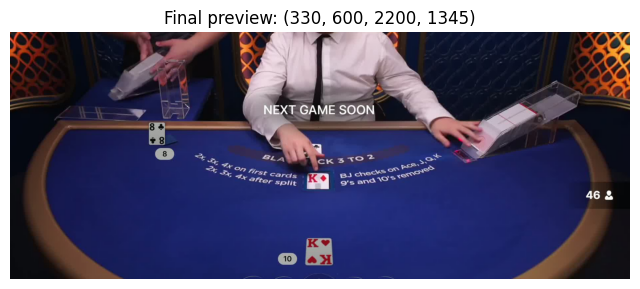

Saved crop config to: C:\Users\floot\Florian's Laptop\ESILV\CV and Deep Learning\ESILV_A5_Computer_Vision\libs\cropping\configs\crop_config.json
{
  "version": 1,
  "created_at_utc": "2025-12-28T11:35:46.757971+00:00",
  "mode": "pixels",
  "crop": {
    "left": 330,
    "top": 600,
    "right": 2200,
    "bottom": 1345
  }
}


In [8]:
if get_config_fn is None:
    print("No interactive config available. Use the manual selection cell to define SELECTED_CONFIG.")
else:
    SELECTED_CONFIG = get_config_fn()
    cropper = BatchCropper(SELECTED_CONFIG)

    # Final preview
    show_image(cropper.crop_image(ref_img), title=f"Final preview: {SELECTED_CONFIG.to_box()}")

    # Save into dataset directory
    saved_path = cropper.save_config()
    print(f"Saved crop config to: {saved_path.resolve()}")
    print(saved_path.read_text(encoding="utf-8"))


## 6) Apply the crop to the entire folder (batch preprocessing)

After calibration, you typically want to generate a fully cropped dataset folder.

This final section applies the crop to every image in `DATASET_DIR` and writes outputs to a sibling folder:
`<DATASET_DIR>__cropped`.

This is useful when:
- you want to cache preprocessing results,
- you want training to be faster (no cropping at runtime),
- you want to freeze the dataset used in an experiment.


In [4]:
# --- Batch application over a full folder ---
folder_cropper = BatchCropper.load_config()

OUTPUT_DIR = DATASET_DIR.parent / f"{DATASET_DIR.name}_cropped"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Apply the crop to every image in DATASET_DIR and save to OUTPUT_DIR
# Notes:
# - overwrite=False will skip files that already exist in OUTPUT_DIR
# - suffix="_crop" avoids collisions if you want to keep the same filenames elsewhere
report = folder_cropper.apply_to_folder(
    input_dir=CROPPING_HELPERS.to_extended_length_path(DATASET_DIR),
    output_dir=CROPPING_HELPERS.to_extended_length_path(OUTPUT_DIR),
    overwrite=False,
    keep_format=True,
    suffix=""
)

display(report)

{'input_dir': "\\\\?\\C:\\Users\\floot\\Florian's Laptop\\ESILV\\CV and Deep Learning\\ESILV_A5_Computer_Vision\\dataset_creation\\assets\\frames_from_videos_clips",
 'output_dir': "\\\\?\\C:\\Users\\floot\\Florian's Laptop\\ESILV\\CV and Deep Learning\\ESILV_A5_Computer_Vision\\dataset_creation\\assets\\frames_from_videos_clips_cropped",
 'processed': 440,
 'skipped': 0,
 'errors': []}